In [1]:
!pip install --upgrade kornia > /dev/null
!pip install --upgrade fastai > /dev/null


Usage:   
  pip <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package archives.
  completion                  A helper command used for command completion.
  debug                    

# **Imports library**

In [3]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure
#import fastai in pytorch library to train model
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# Data Preparation

In [4]:
# Create a meta file for nii files processing 


file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
89,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
243,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii
222,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii
217,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii
252,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii


In [6]:
#split path image and label
df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,../input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,../input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,../input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,../input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii,../input/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii,../input/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii,../input/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii,../input/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [7]:
#Reads .nii file and returns pixel array
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [8]:
# Read sample
sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [9]:
# min and max value
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


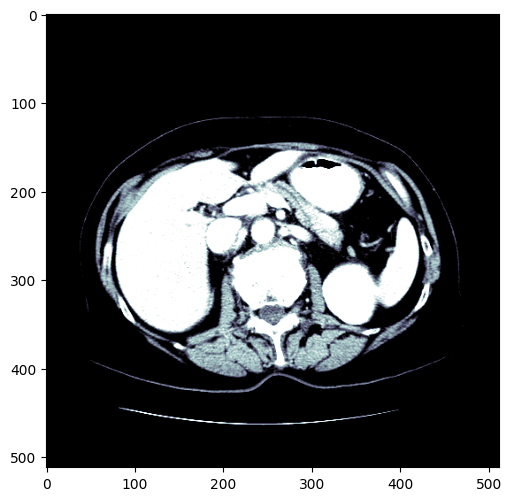

In [10]:
# call name the parts of the people
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)
#function call liver in .nii file
@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)
#show
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [15]:
#Plots and a slice with all available annotations
def plot_sample(array_list, color_map = 'nipy_spectral'):

    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

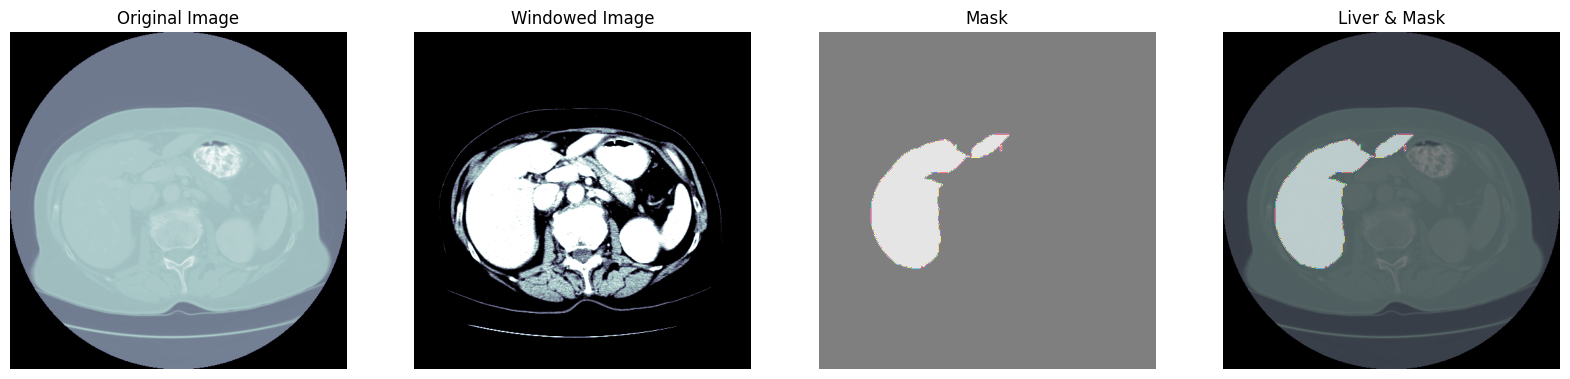

In [16]:
#plot sample 55 
sample = 55

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

In [17]:
# Check the mask values 
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)

[[     0 244111]
 [     1  18033]]


<AxesSubplot:>

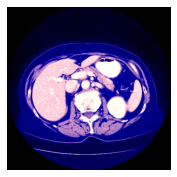

In [18]:
# converts the pixel_array into a TensorCTScan
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    #takes a tensor and wins to creates a new tensor 
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)
#show test image
_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [19]:
# Make custom JPG files for training
# Total number of 131 nii files contains 67072 slices 
path= '/kaggle/working/'
GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/44 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [49]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *
import numpy as np 
import pandas as pd 
from pathlib import Path

In [53]:
# Path to the directory containing train images and masks
path = Path("/kaggle/working/")

In [54]:

# Define batch size and image size
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [55]:
def get_mask_fname(x):
    return path / 'train_masks' / f'{x.stem}_mask.png'

In [56]:
# Create a DataBlock
db = DataBlock(
    blocks=(ImageBlock(), MaskBlock(codes)),
    batch_tfms=[*aug_transforms(size=IMAGE_SIZE), Normalize()],
    splitter=RandomSplitter(),
    get_items=get_image_files,
    get_y=get_mask_fname,
    item_tfms=Resize(IMAGE_SIZE)
)

In [ ]:

# Load the data
dls = db.dataloaders(path / 'train_images', bs=BATCH_SIZE)

In [57]:
# Define the generator architecture
generator = nn.Sequential(
    nn.Linear(100, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 3*IMAGE_SIZE*IMAGE_SIZE),
    nn.Tanh()
)

In [ ]:
# Define the discriminator architecture
discriminator = nn.Sequential(
    nn.Linear(3*IMAGE_SIZE*IMAGE_SIZE, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [58]:

# Define the GAN model
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
    
    def forward(self, x):
        return self.discriminator(x), self.generator(x)

In [59]:
# Initialize the GAN model
gan_model = GAN(generator, discriminator)

In [60]:


# Define the loss function for the generator
def generator_loss(fake_pred):
    return F.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred))

In [61]:
# Define the loss function for the discriminator
def discriminator_loss(real_pred, fake_pred):
    real_loss = F.binary_cross_entropy(real_pred, torch.ones_like(real_pred))
    fake_loss = F.binary_cross_entropy(fake_pred, torch.zeros_like(fake_pred))
    return (real_loss + fake_loss) / 2

In [62]:

# Define the optimizer
optimizer = torch.optim.Adam(gan_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
from tqdm import tqdm

# Number of epochs
num_epochs = 10

# Train the GAN model
for epoch in range(num_epochs):
    # Create a progress bar for each epoch
    progress_bar = tqdm(dls.train, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for real_images, _ in progress_bar:
        batch_size = real_images.size(0)
        real_images = real_images.view(-1, 3*IMAGE_SIZE*IMAGE_SIZE)
        
        # Train discriminator
        noise = torch.randn(batch_size, 100)
        fake_images = generator(noise)
        real_pred = discriminator(real_images)
        fake_pred = discriminator(fake_images.detach())
        disc_loss = discriminator_loss(real_pred, fake_pred)
        disc_loss.backward()
        optimizer.step()
        discriminator.zero_grad()
        
        # Train generator
        noise = torch.randn(batch_size, 100)
        fake_images = generator(noise)
        fake_pred = discriminator(fake_images)
        gen_loss = generator_loss(fake_pred)
        gen_loss.backward()
        optimizer.step()
        generator.zero_grad()
        
        # Update the progress bar with the current loss
        progress_bar.set_postfix(disc_loss=disc_loss.item(), gen_loss=gen_loss.item())


Epoch 1/10:  53%|█████▎    | 269/504 [04:12<03:27,  1.13it/s, disc_loss=0.845, gen_loss=0.231]

In [ ]:
# Save the state dictionaries of generator and discriminator models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
